In [1]:
import astropy.io.fits as pyfits
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import json
import seaborn as sns
from PIL import Image, ImageDraw

%run -i  C:/Users/julie/OneDrive/Bureau/stage/bot_frame_op.py

## Task 1: open a sensor with 16 amplifiers and look to the raw data



#open file of flat data, for one exposure, R22/S11
file_name = 'C:/Users/julie/OneDrive/Bureau/stage/MC_C_/MC_C_20211207_000048_R22_S11_000.fits' 


doss = os.listdir("C:/Users/julie/OneDrive/Bureau/stage/MC_C_") #on fait la liste de tous les fichiers dans notre dossier 
data=(len(doss)) 

"""
#on récupère le nom du fichier 
file=os.path.basename(file_name)
filesplit=os.path.splitext(file)
file=filesplit[0]
print(file)
"""


#ccd_exposure_1000=pyfits.open(file_name)

# Image plotting from P.A.
def plot_ccd_raw(ccd_exposure,contrast=250):
    h=list()
    for i in range(16):
        h.append(plt.hist(np.ravel(ccd_exposure[i+1].data),bins=100))

    #vmin=98000
    #vmax=102000
    window=contrast
    for i in range(16) :
    #    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_col:first_s_over], interval=PercentileInterval(70.))
        plt.subplot(2,8,i+1,title=i+1)
        #plt.imshow(fits[i+1].data[first_line:first_p_over,first_col:first_s_over],cmap = 'hot',origin='lower',norm=norm)

        center=(h[i][1][h[i][0].argmax()]+h[i][1][h[i][0].argmax()+1])/2
        vmin=center-window
        vmax=center+window

        plt.imshow(ccd_exposure[i+1].data,origin='lower',vmin=vmin,vmax=vmax)

        #print (np.mean(fits[i+1].data[first_line:first_p_over,first_col:first_s_over]) )
        if not(i%8 ==0) :
            figure=plt.gca()
            y_axis = figure.axes.get_yaxis()
            y_axis.set_visible(False)
        plt.colorbar()
    plt.show()
    
def parse_section(section_string) :
    # input : a fits-like section string (as in DATASEC '[y0:y1,x0:x1]')
    # output :  image section coordinate to be used in python table:  ymin , ymax ,xmin, xmax
    #
    r=section_string[1:-1].split(',')
    x=list(map(int,r[0].split(':')))
    y=list(map(int,r[1].split(':')))
    # put into pythonic way
    if y[0]<=y[1]:
        y[0] = y[0]-1
    else:
        y[1] = y[1]-1
    if x[0]<=x[1]:
        x[0] = x[0]-1
    else:
        x[1] = x[1]-1
    
    return y[0],y[1],x[0],x[1]

def SingleImageIR(actfile,gains=None):#,first_col=first_col,first_cover=first_s_over,first_line=first_line,first_lover=first_p_over):
        # Display an IR2 image , with amplifiers set at the right place ...there is a DM version which does this better...
        # but here you are in stand alone 
        # the default associated to the image area (pre-overscan excluded) are for e2v IR2 files 
        # if gains is provided, gains are applied
        
#        FileUnBias.all_file[0].Datasec[0]
        # there are also these keywords in actfile, but boundary control is not the same...
        first_line,first_lover,first_col,first_cover=parse_section(actfile.Datasec[0])
        #first_col=actfile.first_col
        #first_cover=actfile.first_s_over
        #first_line=actfile.first_line
        #first_lover=actfile.first_p_over
        
        col_size=first_cover-first_col
        line_size=first_lover-first_line
        #
        spf=np.zeros((line_size*2,col_size*8))

        for i in range(16) :
            y1,y2,x1,x2=parse_section(actfile.Datasec[i])
            yd1,yd2,xd1,xd2=parse_section(actfile.Detsec[i])
            xdir,ydir=(1,1)
            if yd2<yd1:
                ydir=-1
                (yd2,yd1)=(yd1,yd2)
            if xd2<xd1:
                xdir=-1
                (xd2,xd1)=(xd1,xd2)
            if gains is not None:
                raft_ccd=actfile.raftbay+'_'+actfile.ccdslot
                amp='C'+actfile.Extname[i][-2:]
                #print (raft_ccd,amp,gains[raft_ccd][amp])
                spf[yd1:yd2,xd1:xd2]=actfile.Image[i][y1:y2,x1:x2][::ydir,::xdir] * gains[raft_ccd][amp]
            else:
                spf[yd1:yd2,xd1:xd2]=actfile.Image[i][y1:y2,x1:x2][::ydir,::xdir]
        return spf
                
        for i in range(16) :
            if i<8 :
                xx=i*col_size-1
                yy=0
                for x in range(first_col,first_cover) : 
                    #print(xx+col_size-(x-first_col))
                    spf[yy:yy+line_size,xx+col_size-(x-first_col)]=actfile.Image[i][first_line:first_lover,x]
            else :
                xx=(15-i)*col_size
                yy=-1
                for y in range(first_line,first_lover) :  
                    #print(yy+2*line_size-(y-first_line))
                    spf[yy+2*line_size-(y-first_line),xx:xx+col_size]=actfile.Image[i][y,first_col:first_cover]
                    
        return spf
    
def show_image_contrasted(image_data,contrast='auto'):
    med=np.median(image_data)
    if contrast=='auto':
        contrast = 1.5 * stats.iqr(image_data)
    #plt.imshow(image_data,origin='lower',vmin=med-contrast,vmax=med+contrast)
    plt.colorbar()
    
def openfile (name) :  #lecture d'un fichier texte
    F = open ( name )
    i=0
    for line in F:
        i = i+1
    F.close()
    F = open ( name )
    tab = np.zeros((i,2),dtype='f')  #fichier à 4 colonnes   
    il = 0
    for n in range (i):
        A=F.readline()
        B = A[0:-1].split()
        tab[il,:] = [float(x) for x in B]
        il = il + 1
    F.close()
    return tab


#récupère les données de la photodiode
tabP=openfile("photodiode.txt") 
numP = tabP[:,0]   #numéro du fichier
charge =tabP[:,1]  #charge


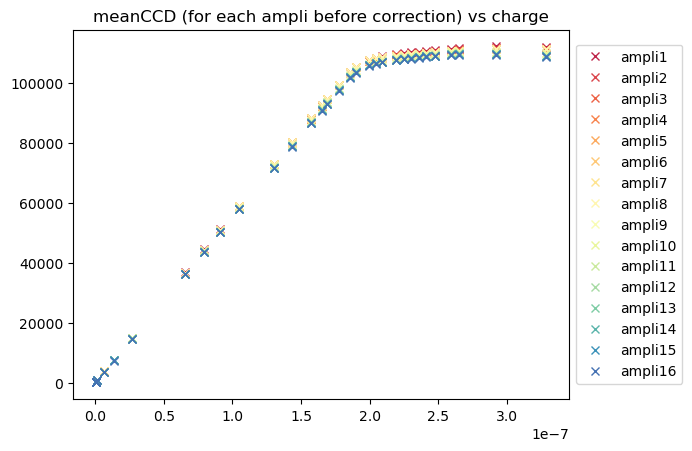

In [2]:
#définition de la palette de couleur
iter = 16
palette = list(reversed(sns.color_palette("Spectral_r", iter).as_hex()))
width_px=1000
new = Image.new(mode="RGB", size=(width_px,120))
for i in range(iter):
    newt = Image.new(mode="RGB", size=(width_px//iter,100), color=palette[i])
    new.paste(newt, (i*width_px//iter,10))

    
    
UnBias='1D'
#UnBias='2D' 


#Pour chaque ampli, on regarde toutes les illuminations     
for p in range (16):
    ampl=[]
    for nb in range (data) :
        file_name = 'C:/Users/julie/OneDrive/Bureau/stage/MC_C_/' + str (doss[nb]) 
        ccd_exposure_1000=pyfits.open(file_name)
        num=file_name.split('_')

        file_list=[file_name]

        # compute unbiased image
        FileUnBias=InFile(dirall=file_list,Slow=False,verbose=False,Bias=UnBias) 
        deoverscanned=SingleImageIR(FileUnBias.all_file[0])

        """
        #show_image_contrasted(deoverscanned)

        # Task 3 : apply the gains
        gains_file_name='13144_ptc_gains.json'

        gains_file=open(gains_file_name)
        gains=json.loads(gains_file.read())
        gains_file.close()
        gains['R22_S11']
        
        #### Gains correction

        deoverscanned_gain=SingleImageIR(FileUnBias.all_file[0],gains)
        #print("deover =", deoverscanned_gain[2002:-1,512])
        #show_image_contrasted(deoverscanned_gain)
        """    
            
        if p <=7:  #amplis 1 à 8 
            ampli=np.mean(deoverscanned[2002:-1,0:512*(p+1)])  
            #ampli=mean_deoverscanned=np.mean(deoverscanned[2002/2,512*(p+1)/2])
            #ampli=deoverscanned[1001,(256)*(p+1)]
        else :  #amplis 9 à 16
            ampli=np.mean(deoverscanned[0:2002,0:512*(p+1-8)])
            #ampli=deoverscanned[1001,(256)*(p+1-8)]
            
        ampl.append(ampli)
    plt.plot(charge, ampl, 'x',color=palette[p],label='ampli'+ str(p+1))  
    #plt.plot(ampl, ampl/charge, '*',color=palette[p],label='ampli'+ str(p+1))  
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('meanCCD (for each ampli before correction) vs charge')
    #plt.xlim(0,100000)
    #plt.ylim(5.4E11,5.8E11)
    plt.savefig('meancharge_ampli_raw')
plt.show()
    
           
    
